In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
conn = sqlite3.connect('/home/greg/Downloads/twitter.db')
df = pd.read_sql("SELECT * FROM covid19tweets WHERE instr(user_loc_display,'United States')>0",conn)
conn.close()

df['created_at'] = pd.to_datetime(df['created_at'])

df['state'] = None

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

assert len(states)==50

In [74]:
for st in states:
    df.loc[
        (df['user_loc_display'].str.contains(st+', ') &
        ~df['user_loc_display'].str.contains('District of Columbia,')
        )
        ,'state'] = st
    
state_counts = df['state'].value_counts(normalize=False).sort_values(ascending=False)

# should be empty set if tweets available in all states
set(states) - set( state_counts.index.to_list() ) 

set()

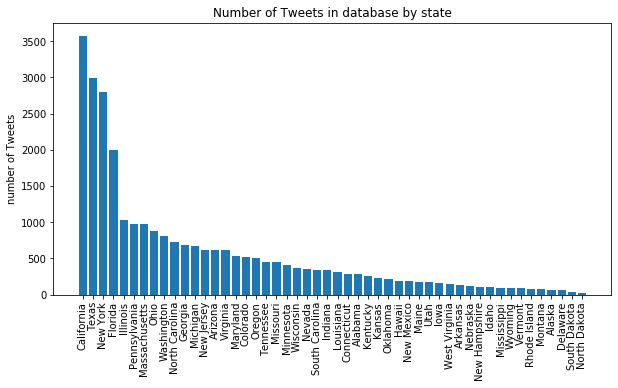

In [75]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(state_counts.index, state_counts.values, align='center')
#ax.set_yticklabels(people)
ax.set_ylabel('number of Tweets')
ax.set_title('Number of Tweets in database by state')
plt.xticks(rotation=90)

plt.show()

# VADER sentiment

In [76]:
# via http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
sentence = 'The situation involving covid19 is getting better.'
analyser.polarity_scores(sentence)['compound']

0.4404

In [77]:
for i,row in df.iterrows():
    df.at[i,'vader'] = analyser.polarity_scores(row['text'])['compound']

In [78]:
df['vader'].mean()

-0.008606854322221878

In [79]:
df['dayofyear'] = df['created_at'].dt.dayofyear

In [80]:
df_temp = df[['state','vader','dayofyear']].groupby(['state','dayofyear']).mean()
df_temp.head()

vader
state   dayofyear          
Alabama 82        -0.073073
        83        -0.023243
        84        -0.047744
        85        -0.087180
        86        -0.018944

In [81]:
sentiment_by_day_and_state = df_temp.reset_index().pivot(index='state',columns='dayofyear',values='vader')
sentiment_by_day_and_state.head()

dayofyear,82,83,84,85,86
state,,,,,
Alabama,-0.073073,-0.023243,-0.047744,-0.087180,-0.018944
Alaska,-0.232850,-0.152890,-0.134654,0.152583,0.081983
Arizona,0.076925,-0.099599,-0.038484,0.026690,-0.017129
Arkansas,-0.216517,-0.158397,-0.080700,-0.037306,-0.281047
California,-0.020438,-0.044486,0.028085,-0.016810,-0.021522


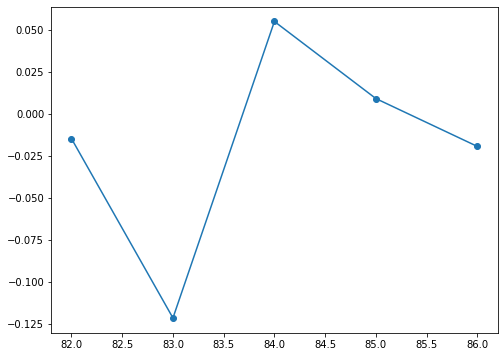

In [82]:
state = 'Michigan'


st_data = sentiment_by_day_and_state.loc[state]
st_data.values    

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(st_data.index, st_data.values,'o-',label=state)

# plotting state sentiment from 10 states with most tweets

In [83]:
import datetime

def doy_to_date(dayofyear):
    return datetime.datetime.strptime('2020 '+str(dayofyear), '%Y %j').strftime('%b %d')

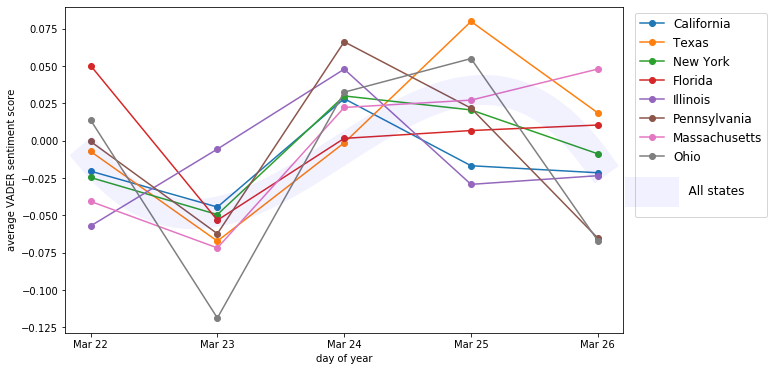

In [143]:
# plotting

from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(figsize=(10, 6))

for state in state_counts.index[:8]:
    st_data = sentiment_by_day_and_state.loc[state]
    ax.plot(st_data.index, st_data.values,'o-',label=state)

overall = df[['dayofyear','vader']].groupby('dayofyear').mean()
spl = UnivariateSpline(overall.index, overall.values)
spl.set_smoothing_factor(1)
xs = np.linspace(min(overall.index),max(overall.index),100)
plt.plot(xs, spl(xs), 'b', lw=30,alpha=0.05,label='\n    All states\n')

ticks = list(sentiment_by_day_and_state.loc['Michigan'].index)


fontP = FontProperties()
fontP.set_size('large')
ax.legend(bbox_to_anchor=(1.01, 1),prop=fontP)


plt.xticks(ticks=ticks,labels = [doy_to_date(tick) for tick in ticks])
plt.xlabel('day of year')
plt.ylabel('average VADER sentiment score')



plt.show()



In [95]:
max(overall.index)

86

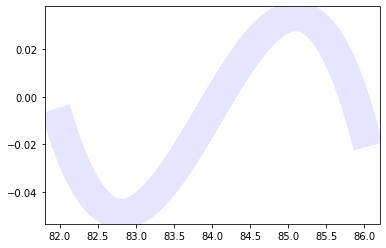

In [120]:
from scipy.interpolate import UnivariateSpline
import numpy as np



# sampling highest sentiment tweets

In [86]:
df[df['vader']>0.9]['text'].value_counts().nlargest(5)

RT @lsarsour: A Palestinian shoemaker started the West Bank’s only mask factory overnight. I love my people. So kind, so brilliant, so resi…            30
RT @bamableu: This is the America I know &amp; love. \n\nHeroes volunteering to be on the front lines. \n\nThank you to all the brave souls who are…     8
RT @radioheadfloyd: Never thought I’d say this but @BernieSanders sure seems like the most competent, adept and proactive candidate during…              8
RT @Cocofritz: .@GovAbbott HALTS ABORTION during #COVID19! I LOVE TX &amp; this governor! No one is exempt -- health &amp; safety for ALL! Those wh…     4
RT @MoveOn: .@staceyabrams said it best: we need immediate action to protect the health and safety of voters and the integrity of our elect…             3
Name: text, dtype: int64

In [101]:
nostate = df[df['state'].isnull()]